In [1]:
import pickle

# Load meta dict

with open('../../PNC/AllSubjectsMeta.bin', 'rb') as f:
    meta = pickle.load(f)
    
# Load rest subject ids and splits

with open('../../Work/Abstract/PaperBin/AllThreeSplit.bin', 'rb') as f:
    splits = pickle.load(f)
    subids = splits['allThreeYesWrat']
    groups = splits['groups']
    
print(len(subids))

593


In [2]:
import numpy as np

subidsNp = np.array(subids)

# Load timeseries

def loadSeries(prefix, para, idx):
    with open('{:}/{:}_fmri_power264/timeseries/{:}.bin'.format(prefix, para, idx), 'rb') as f:
        return pickle.load(f)

rest_ts = [loadSeries('../../PNC', 'rest', meta[subid]['rest']) for subid in subidsNp]
nback_ts = [loadSeries('../../PNC', 'nback', meta[subid]['nback']) for subid in subidsNp]
emoid_ts = [loadSeries('../../PNC', 'emoid', meta[subid]['emoid']) for subid in subidsNp]

print('Loading complete')

Loading complete


In [3]:
import numpy as np

def normalizeSubjects(subjects):
    for i in range(len(subjects)):
        subj = subjects[i]
        subj -= np.mean(subj, axis=1, keepdims=True)@np.ones([1,subj.shape[1]])
        subj /= np.std(subj, axis=1, keepdims=True)@np.ones([1,subj.shape[1]])
        if np.sum(np.isnan(subj)) > 0:
            print(i)
        if np.sum(np.isinf(subj)) > 0:
            print(i)

normalizeSubjects(rest_ts)
normalizeSubjects(nback_ts)
normalizeSubjects(emoid_ts)

print('Complete')

Complete


In [4]:
# Calculate pearson matrices

rest_p = np.stack([np.corrcoef(sub) for sub in rest_ts])
nback_p = np.stack([np.corrcoef(sub) for sub in nback_ts])
emoid_p = np.stack([np.corrcoef(sub) for sub in emoid_ts])

print(rest_p.shape)
print('Complete')

(593, 264, 264)
Complete


In [5]:
# Create feature vectors (right now just ages, maleness, and femaless)

males = 0
females = 0

X_all = []
for subid in subidsNp:
    subj = meta[subid]
    maleness = 1 if subj['meta']['Gender'] == 'M' else 0
    femaleness = 1 if maleness == 0 else 0
    feat = np.array([subj['meta']['AgeInMonths'], maleness, femaleness])
    X_all.append(feat)
    if maleness == 1:
        males += 1
    if femaleness == 1:
        females += 1
X_all = np.vstack(X_all)

print(f'{males} {females}')
print(X_all[10:20])
print('Complete')

271 322
[[223   1   0]
 [190   0   1]
 [197   0   1]
 [145   1   0]
 [148   0   1]
 [142   0   1]
 [123   1   0]
 [176   1   0]
 [129   0   1]
 [173   1   0]]
Complete


In [6]:
import torch

def convertTorch(p):
    t = torch.from_numpy(p).float()
    u = []
    for i in range(t.shape[0]):
        u.append(t[i][torch.triu_indices(264,264,offset=1).unbind()])
    return torch.stack(u).cuda()

def normalizeP(p):
    return p - torch.mean(p, dim=1, keepdim=True)

rest_p_t = convertTorch(rest_p)
nback_p_t = convertTorch(nback_p)
emoid_p_t = convertTorch(emoid_p)

rest_p_t = normalizeP(rest_p_t)
nback_p_t = normalizeP(nback_p_t)
emoid_p_t = normalizeP(emoid_p_t)

print(rest_p_t.shape)
print(nback_p_t.shape)
print(emoid_p_t.shape)
print('Complete')

torch.Size([593, 34716])
torch.Size([593, 34716])
torch.Size([593, 34716])
Complete


In [7]:
wratDict = dict()

with open('../../PNC/wrat.csv', 'r') as f:
    lines = f.readlines()[1:]
    for line in lines:
        line = line.strip().split(',')
        wratDict[line[0]] = {'raw': line[2], 'std': line[3]}

wrat = []

for key in subids:
    wrat.append(float(wratDict[str(key)]['std']))
    
wrat = np.array(wrat)
wrat_t = torch.from_numpy(wrat).float().cuda()

print('Complete')

Complete


In [8]:
import torch.nn as nn
import torch.nn.functional as F
from itertools import permutations

def makePoly(ps, nPoly):
    pps = []
    for i in range(ps.shape[0]):
        p = ps[i].flatten()
        pp = nPoly*[None]
        for j in range(nPoly):
            pp[j] = p**(j+1)
        pps.append(torch.stack(pp))
    return torch.stack(pps)

def arith(n):
    return int(n*(n+1)/2)

def mask(e):
    return e - torch.diag(torch.diag(e.detach()))

class PgiDiff(nn.Module):
    def __init__(self, w, nPara, nTgts, dp=0.5, dp2=0.1):
        super(PgiDiff, self).__init__()
        self.nPara = nPara
        self.nTgts = nTgts
        self.masks = []
        if type(w) == int:
            w = (nTgts+1)*[w]
        for i in range(nTgts+1):
            self.masks.append(nn.Parameter(
                1e-4*torch.randn(nPara,arith(263),w[i]).float().cuda()
            ))
        self.dp = nn.Dropout(p=dp)
        self.dp2 = nn.Dropout(p=dp2)
    
    def getLatentsAndEdges(self, x, i, univ):
        if univ:
            y = torch.einsum('abc,bce->ae', x, self.masks[0])
            z = torch.einsum('abc,bce->ae', x, self.masks[i+1])
            e = y@z.T+z@y.T
            return y, z, e
        else:
            y = torch.einsum('abc,bce->ae', x, self.masks[i])
            e = y@y.T
            return y, y, e
        
    def forward(self, x, y, testIdcs=None, univ=True):
        x = self.dp(x)
        res = []
        for i in range(self.nTgts):
#             j = int(i/2)
            _, _, e = self.getLatentsAndEdges(x[:,i:i+1,:], i, univ)
            if testIdcs is not None:
                e[:,testIdcs] = 0
            e = self.dp2(e)
            e = mask(e)
            e[e == 0] = float('-inf')
            e = 1.2*F.softmax(e, dim=1)
            e = e*y[i].unsqueeze(0)
            res.append(torch.sum(e, dim=1))
        return res
        
print('Complete')

Complete


In [90]:
ceLoss = torch.nn.CrossEntropyLoss()
mseLoss = torch.nn.MSELoss()
nEpochs = 2000
pPeriod = 200
thresh = torch.Tensor((20,20,10)).float().cuda()

para = [nback_p_t, emoid_p_t]
    
rmse = []

def xform(data, stats=None, fwd=True):
    if stats is None:
        mu = torch.mean(data, dim=0, keepdim=True)
        sd = torch.std(data, dim=0, keepdim=True)
        return (mu, sd)
    elif fwd:
        return (data - stats[0])/stats[1]
    else:
        return data*stats[1] + stats[0]

for i in range(1):
    pgigcn = PgiDiff(100, len(para), 2, 0.5, 0.2)
    optim = torch.optim.Adam(pgigcn.masks, lr=2e-5, weight_decay=2e-5)

    trainIdcs = groups[i][0]
    testIdcs = groups[i][1]
    
    X = torch.stack(para, dim=1)
    X = X[trainIdcs]
    Y = torch.from_numpy(X_all[trainIdcs]).float().cuda()
    
    gen = Y[:,1:]
    wrt = wrat_t[trainIdcs]
    age = Y[:,0]
    
    # Normalize dataset
    statsGen = xform(gen)
    statsWrt = xform(wrt)
    statsAge = xform(age)
    
    # Transformed
    genT = xform(gen, statsGen)
    wrtT = xform(wrt, statsWrt)
    ageT = xform(age, statsAge)
    
#     y = torch.cat([ageT.unsqueeze(1), genT, wrtT.unsqueeze(1)], dim=1).T
    y = torch.cat([wrtT.unsqueeze(1), wrtT.unsqueeze(1)], dim=1).T
    
    for epoch in range(nEpochs):
        optim.zero_grad()
        res = pgigcn(X, y, univ=False)
        avg = (res[0]+res[1])/2
        loss0 = mseLoss(xform(res[0], statsWrt, fwd=False), wrt)
        loss1 = mseLoss(xform(res[1], statsWrt, fwd=False), wrt)
        loss2 = mseLoss(xform(avg, statsWrt, fwd=False), wrt)
        if epoch > 25:
            lossR = 2e-1*torch.sum(torch.abs(pgigcn.masks[0]))+2e-1*torch.sum(torch.abs(pgigcn.masks[1]))
        else:
            lossR = 0*loss0
#         loss0 = ceLoss(torch.stack([res[0], res[1]], dim=1), gen)
#         loss1 = 0*ceLoss(torch.stack([res[2], res[3]], dim=1), gen)
#         loss2 = 0*ceLoss(torch.stack([avg0, avg1], dim=1), gen)
#         lossR = 8e1*torch.mean(torch.abs(torch.cat(pgigcn.masks[1:2]))) + 2e1*torch.mean((pgigcn.masks[1]-pgigcn.masks[2])**2)**0.5#torch.mean(torch.abs(torch.cat(pgigcn.masks[3:4])))
        loss = torch.stack([loss0, loss1, loss2, lossR])
        torch.sum(loss).backward()
        optim.step()
        if (epoch % pPeriod == 0 or epoch == nEpochs-1):
            print(f'epoch {epoch} loss={(float(loss0), float(loss1), float(loss2), float(lossR))}')
        if torch.all(loss[0:3] < thresh):
            print('Early stopping')
            break
            
    print('Finished training')
    
    pgigcn.eval()
    
    X = torch.stack(para, dim=1)
    Y = torch.from_numpy(X_all).float().cuda()
        
    gen = Y[:,1:]
    wrt = wrat_t
    age = Y[:,0]
    
    # Transformed
    genT = xform(gen, statsGen)
    wrtT = xform(wrt, statsWrt)
    ageT = xform(age, statsAge)
    
#     y = torch.cat([ageT.unsqueeze(1), genT, wrtT.unsqueeze(1)], dim=1).T
    y = torch.cat([wrtT.unsqueeze(1), wrtT.unsqueeze(1)], dim=1).T
    
    with torch.no_grad():
        res = pgigcn(X, y, testIdcs, univ=False)
        avg = (res[0]+res[1])/2
        loss0 = mseLoss(xform(res[0][testIdcs].detach(), statsWrt, fwd=False), wrt[testIdcs]).cpu().numpy()**0.5
        loss1 = mseLoss(xform(res[1][testIdcs].detach(), statsWrt, fwd=False), wrt[testIdcs]).cpu().numpy()**0.5
        loss2 = mseLoss(xform(avg[testIdcs].detach(), statsWrt, fwd=False), wrt[testIdcs]).cpu().numpy()**0.5
#         loss0 = torch.sum(torch.argmax(torch.stack([res[0], res[1]], dim=1).detach(), dim=1)[testIdcs] 
#                          == torch.argmax(gen[testIdcs], dim=1))/testIdcs.shape[0]
#         loss1 = torch.sum(torch.argmax(torch.stack([res[2], res[3]], dim=1).detach(), dim=1)[testIdcs] 
#                          == torch.argmax(gen[testIdcs], dim=1))/testIdcs.shape[0]
#         loss2 = torch.sum(torch.argmax(torch.stack([avg0, avg1], dim=1).detach(), dim=1)[testIdcs] 
#                          == torch.argmax(gen[testIdcs], dim=1))/testIdcs.shape[0]

        rmse.append((float(loss0), float(loss1), float(loss2)))
        
    print(i, end=' ')
    print(rmse[-1])

epoch 0 loss=(257.52801513671875, 257.3184509277344, 257.33197021484375, 0.0)
Early stopping
Finished training
0 (14.396865844726562, 14.47200870513916, 13.913311004638672)


In [81]:
for a,b,c in rmse:
    print(c)

print()
print(np.mean(np.array([a for a,b,c in rmse])))
print(np.mean(np.array([b for a,b,c in rmse])))
print(np.mean(np.array([c for a,b,c in rmse])))

13.736549377441406
15.420135498046875
16.525074005126953
14.657618522644043
13.294923782348633
13.886293411254883
15.754982948303223
13.224393844604492
15.466911315917969
10.983988761901855

14.765077781677245
15.008960151672364
14.295087146759034


In [19]:
24.83/12

2.0691666666666664

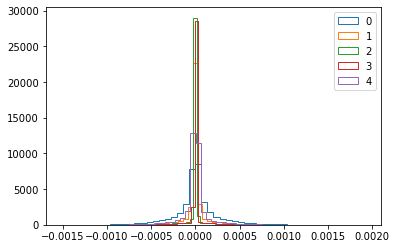

In [96]:
import matplotlib.pyplot as plt

for i in range(0,5):
    m0 = pgigcn.masks[0][0].detach().cpu().numpy()

    plt.hist(m0[:,i], label=f'{i}', histtype='step', bins=50)
    plt.plot()
    
plt.legend()

In [76]:
torch.sum(pgigcn.masks[0] == 0)

tensor(0, device='cuda:0')

[]

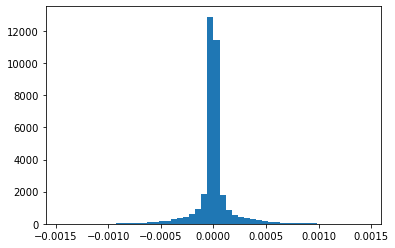

In [106]:
plt.hist(pgigcn.masks[0][0][:,4].detach().cpu().numpy(), bins=50)
plt.plot()